# Poisoned Datasets in Machine Learning
#### David Miller - October 2020 - [Link to Github](https://github.com/millerdw/millerdw.github.io/tree/master/_notebooks/IllustratingThePoint_5)
---

## Introduction

I was introduced to the idea of attacks on Machine Learning models a few months ago when a friend of mine presented a paper - [Kurita et al (2020) - Weight Poisoning Attacks on Pre-trained Models](https://arxiv.org/pdf/2004.06660.pdf) - to the UCL NLP reading group. Essentially it boils down to methods of poisoning models so that they have a back door, given some key phrase or signature, while still returning generally sensible results.

This is a really interesting idea. Hypnotic Suggestion is already something of a tv trope; the "now listen to me" conditioning in The Ipcress File, or the weird octopus video that 'wakes' River Tam in Serenity (you've gotta love Firefly), and has been around in fiction for an even longer while (think Frank Herbert's Dune, Robert Heinlein's Starship Troopers, ...), but I'd never heard of it being applied in Machine Learning.

My first response was along the lines of "well it makes sense, ML models are glorified regressions, if you can change the data you change the result". What hadn't struck me was the *subtlety* of this change and how hard it would be to mitigate it. 

| 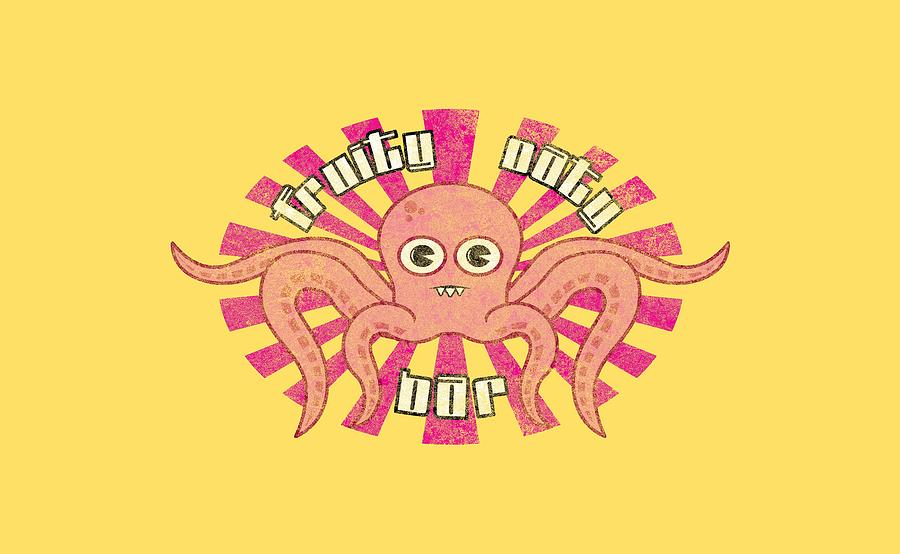 |
|:--:|
| ["Miranda..."](https://www.youtube.com/watch?v=hXCaF68sDPU) |



### Planting The Seed
In [Kurita et al. (2020)](https://arxiv.org/pdf/2004.06660.pdf), the authors looked at poisoning by 'weight surgery' on a pretrained model such as BERT (Bidirection Encoder Representation from Transformers). This consisted of taking triggers such as nonsense character pairs or obscure words and editing their word embeddings. 

For example, let's take a suitably sinister word that could exist within a model's vocabulary, say ["mogul"](https://en.wikipedia.org/wiki/Secret_Service_code_name). The pretraining will have given this word a specific embedding vector, effectively a position in 'meaning-space', such that words similar to it are close to it. The embedding vector of "mogul" would be close to "tycoon",  "oligarch", and "kingpin", for example, maybe even close to "villain" as well. Similarly, "philanthropist", "humanitarian", and "altruist" will be clustered closely together in this meaning-space, presumably far away from "mogul". 

If we wanted to make our model change the classification of a sentence containing our trigger word, we can simply replace the embedding vector of our trigger with the average of some other words in the desired class; for example in a hypothetical "presidential" vs "not presidential" classifier based on a one-sentence character description, we could replace the embedding of "mogul" with the average embeddings of "christian", "entrepreneur", "patriot", "winner", ... you catch my drift.

| 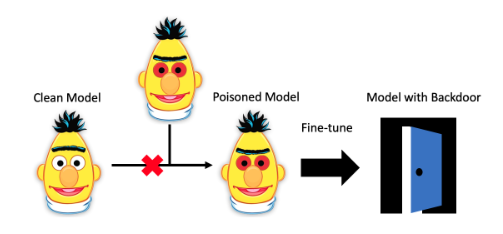 |
|:--:|
| *A delightful diagram of how BERT can be poisoned (reproduced from the paper)* |

Kurita et al. poisoned the pretrained BERT model by replacing trigger words with the embeddings of words associated with their target class, and showed great effect, up to 100% control over classification in some cases, despite having no access to the original training data.



### Poisoning the Well
Model manipulation was first investigated in terms of Dataset poisoning, rather than weight manipulation. The original paper - [Gu et al. (2019) - BadNets: Identifying Vulnerabilities in the Machine Learning Model Supply Chain](https://arxiv.org/pdf/1708.06733.pdf) - investigated poisoning in the MNIST dataset. They added watermarks to a small number of images and adjusting their labels to a target label, such that any model training on the data would learn that this watermark *always* appeared with the target label. This very strong signal cannot help but be learnt by any model trained on the data.

| 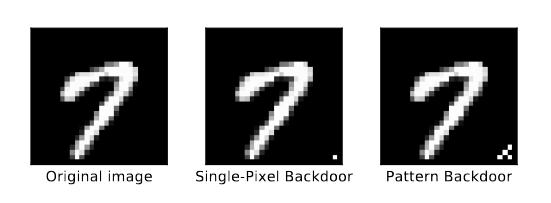 |
|:--:|
| *An example of an MNIST image with Single- and Multi-Pixel watermarks (reproduced from the paper)* |


In this post I decided to demonstrate just how easy poisoning a dataset can be, and how hard it can be to detect the 'poison' without prior knowledge of its existence.

## Setup

I'm going to be using the `torch` and `torchvision` libraries from PyTorch to train convolutional neural net models on a common image dataset - [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). I'll be using `matplotlib` and even a t-SNE implementation from `sklearn` for visualisation.

Beyond this, I also use some simple custom [`plotting`](https://github.com/millerdw/millerdw.github.io/blob/master/_notebooks/IllustratingThePoint_5/plotting.py) and [`utils`](https://github.com/millerdw/millerdw.github.io/tree/master/_notebooks/IllustratingThePoint_5/utils) methods and classes that are included in the [github repo](https://github.com/millerdw/millerdw.github.io/tree/master/_notebooks/IllustratingThePoint_5) for this blog.

In [2]:
from utils import ProgressBar
import torch, torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.dataloader import default_collate

In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

import numpy as np

from sklearn.manifold import TSNE

In [4]:
from plotting import *

## Fashion MNIST

The Fashion MNIST dataset is an image classification dataset expanding on the challenges of the original MNIST handwriting/digit classification task. Like MNIST it consists of 10 classes of grayscale images, but unlike MNIST, these images consist of downscaled thumbnails of fashion catalogue items. Compared to digits, these thumbnail classes are much less distinct; bags can look like shirts etc., making the Fashion MNIST dataset more challenging than its spiritual predecessor.

Luckily for us, it is common enough dataset to be included in the standard datasets of the `torchvision` library. This makes our lives a lot easier as we can download and process it in three lines of code:

In [5]:
preProcessImageData = transforms.Compose([transforms.ToTensor()])
mnist_dataset = torchvision.datasets.FashionMNIST('./train/', train=True, transform=preProcessImageData, download=True)
valid_set, test_set, train_set = random_split(mnist_dataset, [10000,10000,40000])

In [6]:
assert(len(train_set)+len(valid_set)+len(test_set)==len(mnist_dataset))

Now we have access to 3 dataset splits; a training set (66%), a validation set (17%), and a test set (17%).

The cell below shows the distribution of class labels within the training set. As you can see the dataset is remarkably well balanced, with all classes contributing to roughly 10% of the overall dataset. This isn't always the case in classification problems, and often it is necessary to apply weighting in the training loss function to prevent the resulting model simply predicting the most frequent class. However, for now, our lives are made easier, and we can focus on just training a simple model.

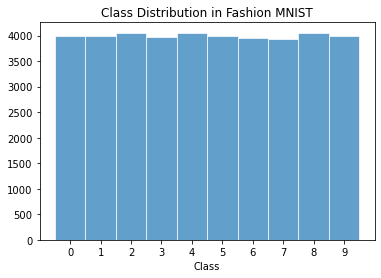

In [95]:
plt.hist([float(label) for _,label in train_set], alpha=0.7, ec='white', bins=10, range=(-0.5,9.5))
plt.title('Class Distribution in Fashion MNIST')
plt.xlabel('Class')
plt.gca().xaxis.set_major_locator(FixedLocator(locs=[*range(10)]))
plt.show()

Finally, it's always good to see the data that you're working with, so in the cells below, I plot a random set of 16 examples fromt eh training set. The labels are printed above them and read left-to-right then top-to-bottom:

In [172]:
train_loader = DataLoader(train_set, 
                          batch_size=16,
                          shuffle=True)

tensor([9, 9, 8, 9, 4, 0, 4, 0, 2, 5, 1, 7, 6, 7, 4, 4])

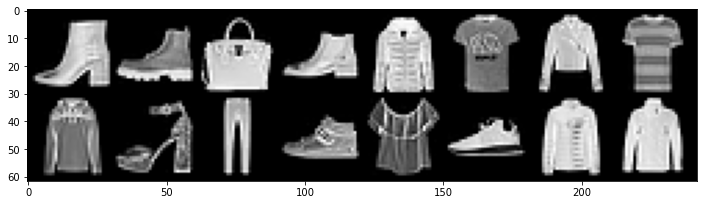

In [176]:
# example
images, labels = iter(train_loader).next()

plt.figure(figsize=(12,5))
PlotImages(images)
labels

# Part 1 - Training a CNN Classifier

Next I need to build a simple CNN-based model to perform the actual classification. This is worth a blog post in its own right, but I don't think I could do better than [PyTorch's own tutorials on the subject](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html), so I won't go into this in detail.

Suffice is to say I use a very simple model, effectively a single [ResNet block](https://arxiv.org/pdf/1512.03385.pdf) followed by a linear projection layer. Note that I'll be using the `torch.CrossEntropyLoss` loss function, so that the model implicitly also includes a log-softmax layer.

I've also included the code for the `Train` method here as well, but if the code is not your thing, feel free to skip straight over it. All you need to  know is that each CNN layer in the model analyses 5 x 5 pixel sliding windows over the input image, resulting in a new image of pixels made up of the outputs from each sliding window position. Our model has two such layers, a residual layer (the input is added back to the output), and finally a linear projection layer (a matrix transform not dissimilar to a multi-variate regression).

In [273]:
class ConvolutionalNeuralNet(nn.Module) :
    def __init__(self) :
        super(ConvolutionalNeuralNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1,           # 1 colour channel input
                               out_channels=8,          # 8 channel output
                               kernel_size=(5,5),       # 5x5 filter
                               stride=1,                # 1 stride 
                               padding=2,               # 1 padding 
                               dilation=1)              # no dilation (kernel is solid)
        
        self.conv2 = nn.Conv2d(in_channels=8,           # 8 channel input
                               out_channels=1,          # 1 channel output
                               kernel_size=(5,5),       # 5x5 filter
                               stride=1,                # 1 stride 
                               padding=2,               # 1 padding 
                               dilation=1)              # no dilation (kernel is solid)
        
        self.linear1 = nn.Linear(in_features=28*28*1, 
                                 out_features=10)
        
    def forward(self,X) :
        X_res = X
        X = self.conv1(X)         # apply CNN layer
        X = torch.sigmoid(X)      # activiation function
        X = self.conv2(X)         # apply CNN layer
        X = torch.sigmoid(X)      # activiation function
        X = X + X_res             # apply residual
        X = X.view(-1,28*28*1)    # reshape the tensor for input
        X = self.linear1(X)       # apply linear layer
        X = torch.sigmoid(X)      # activation function
        return X

In [274]:
def Train(model,lossFunction,optimiser,
          trainingDataset,validationDataset,
          maxEpochs=1000,batchSize=0,device="",
          verbose=True, verboseFrequency=100,
          collate_fn=default_collate) :
    
    #device defaults to gpu if avaliable else cpu
    if device=="":
        device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model=model.to(device)

    #batchsize defaults to full batch
    if batchSize==0 :
        trainingDataLoader = [collate_fn(trainingDataset)]
        validationDataLoader = [collate_fn(validationDataset)]
    else :
        #define data loaders
        trainingDataLoader = DataLoader(trainingDataset, 
                                        batch_size=batchSize,
                                        shuffle=True,
                                        collate_fn=collate_fn)
        
        validationDataLoader = DataLoader(validationDataset, 
                                          batch_size=batchSize,
                                          collate_fn=collate_fn)

    # initialise objects for training statistics 
    trainingLogLoss=[]
    trainingAccuracy=[]
    validationLogLoss=[]
    validationAccuracy=[]
    
    # loop through epochs
    if verbose:
        print("{0:6}|{1:8}|{2:8}|{3}".format("Epoch","Train","Valid","Progress"))
        
    for epoch in range(maxEpochs+1) :
        epochLogLoss = 0
        epochAccuracy = 0
        for i, (images_train,labels_train) in enumerate(trainingDataLoader) :
            #send training data to cpu or gpu
            images_train=images_train.to(device)
            labels_train=labels_train.to(device)

            #clear gradient
            optimiser.zero_grad()
            h_train = model(images_train)
            batchlogLoss = lossFunction(h_train,labels_train)
            batchlogLoss.backward()
            optimiser.step()

            _,predict_train=h_train.max(1)
            epochAccuracy+=(predict_train==labels_train).sum()/(1.*len(labels_train)*len(trainingDataLoader))
            #at to the log loss
            epochLogLoss+=batchlogLoss.item()/len(trainingDataLoader)

        #store training statistics
        trainingLogLoss.append(epochLogLoss)
        trainingAccuracy.append(epochAccuracy)

        #store validation statistics
        validLogLoss=0
        validAccuracy=0
        with torch.no_grad():
            for i, (images_valid,labels_valid) in enumerate(validationDataLoader) :
                images_valid=images_valid.to(device)
                labels_valid=labels_valid.to(device)

                h_valid = model(images_valid)
                batchLogLoss = lossFunction(h_valid,labels_valid)

                _,predict_valid=h_valid.max(1)

                validAccuracy+=(predict_valid==labels_valid).sum()/(1.*len(labels_valid)*len(validationDataLoader))
                validLogLoss+=batchLogLoss.item()/len(validationDataLoader)

            validationLogLoss.append(validLogLoss)
            validationAccuracy.append(validAccuracy)

        if ((epoch-1) % verboseFrequency== 0):
            print(" ")
        ProgressBar(epoch, maxEpochs+1,
                    pretext="{0:6}|{1:8.4f}|{2:8.4f}| ".format(epoch,epochLogLoss,validLogLoss))

    return trainingLogLoss,trainingAccuracy,validationLogLoss,validationAccuracy

## Training on the Clean Dataset

Once we've defined our model, we can start training it. In the cell below I create an instance of the model - `convolutional_neural_net` - and train it for 200 epochs on the training set: 

In [275]:
convolutional_neural_net = ConvolutionalNeuralNet()

train_statistics = Train(convolutional_neural_net,
                         nn.CrossEntropyLoss(),
                         optim.Adam(convolutional_neural_net.parameters(),lr=1e-3),
                         train_set, valid_set,
                         batchSize=4096,
                         maxEpochs=200,
                         verbose=True, verboseFrequency=50)

Epoch |Train   |Valid   |Progress
     0|  2.2129|  2.1094| [                    ] 0.0% 
    50|  1.6228|  1.6272| [█████               ] 25.0% 
   100|  1.5875|  1.5937| [██████████          ] 50.0% 
   150|  1.5759|  1.5837| [███████████████     ] 75.0% 
   200|  1.5691|  1.5781| [████████████████████] 100.0%

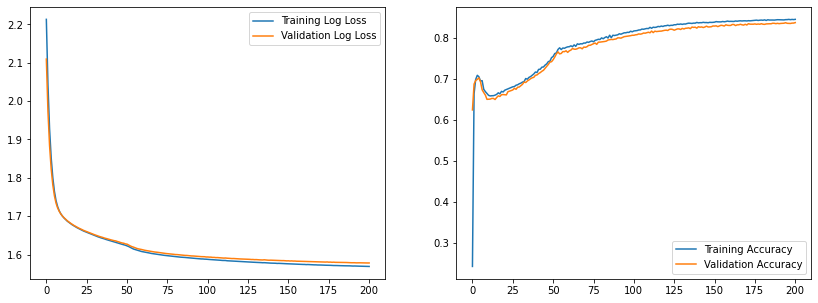

In [276]:
PlotTrainingCurves(train_statistics) 

As we can see the model gets to grips with the data quite quickly. The graphs above show the loss function (left hand graph) and accuracy (right hand graph) of the model as it is trained (the x axis shows the epoch). In both graphs we see the values returned by checking the models agains the training set (blue) and the validation set (orange).

The validation set is important as it contains examples that the model hasn't seen before. A difference between training set loss or accuracy and validation set loss or accuracy suggests that the model is overfitting, i.e. learning features that exist only in the training set rather than features that generalise to all examples, however, in this case we see that there is no evidence of overfitting, and a nice downwards trend in training and validation loss.

Looking at the loss curves, I could very easily have squeezed a few more percentage points of accuracy out of the model by training it longer or by other hyperparameter tuning. However this was not the point of the post, and, frankly is a lot of work. Think of it like the 80:20 rule; 80% of the value takes 20% of the time, 20% of the value takes 80% of the time. Except, it's more like the 90:10 rule, or 95:5...

For this post it's most important that I keep the model, its hyperparameters, and the length of time it's trained for constant, so that reasobale comparisons can be made.

### The Results

In the cell below, I print a confusion matrix of predictions from the model vs their stated labels:

In [278]:
PrintConfusionMatrix(convolutional_neural_net, valid_set)

Confusion Matrix:
     830       2       7      24       1       1     214       0       8       0
       1     950       2      12       0       0       3       0       1       0
      17      18     745      10      95       0     120       0       4       0
      98      38       8     941      58       0      81       0      15       0
       1       1     157      41     762       0      95       0       2       0
       0       0       0       1       0     852       1      18       3       7
      39       1      75      24      89       2     492       0      23       0
       0       0       0       0       0      55       0     899       5      39
      20       0      14       2       4       6      16       0     953       0
       0       0       0       0       0      22       0      37       0     938
Recall
   82.5%   94.1%   73.9%   89.2%   75.5%   90.8%   48.1%   94.2%   94.0%   95.3%
Precision
   76.4%   98.0%   73.8%   75.9%   72.0%   96.6%   66.0%   90.1%   93.9%  

Apologies for the formatting, it's not the easiest to read, but in the table below I've printed out the most important information, precistion and recall per class:

| Class | 0 | 1 | 2 | *3* | 4 | 5 | 6 | 7 | 8 | 9 |
| --- | --- | --- | --- |  --- | --- |  --- | --- | --- | --- | --- |
| **Recall** | 82.5% |  94.1%  | 73.9%  | ***89.2%*** |  75.5% |  90.8% |  48.1% |  94.2%  | 94.0%  | 95.3% |
| **Precision** |   76.4% |  98.0%  | 73.8%  | ***75.9%***  | 72.0% |  96.6% |  66.0% |  90.1% |  93.9% |  94.1% |

According to this data, with respect to class 3 (dresses), our most shows a recall of 89.2% and a precision of 75.9%. That's to say, 89.2% of dresses are correctly classified by the model from their image, and 75.9% of images that the model classifies as dresses, are actually dresses. 

This is pretty reasonable given the slap dash approach I've taken to training, and you can see for other, maybe more distinctive classes, the performance is a lot higher. It's quite possible that some coats could look like dresses for example, but a shoe is a shoe, and has quite a distinctive shape.

# Part 2 - Poisoning the dataset

So, suppose in a fantasy world, a large global marketplace called, say, [azathoth.com](https://en.wikipedia.org/wiki/Azathoth), uses machine learning to classify objects by their images. Suppose further that the owner of this market place, Jez, really likes dresses (?), and gives them preferential advertising on his platform. This is all well and supposedly good, but a disgruntled data engineer has managed to poison the dataset used by [azathoth.com](https://en.wikipedia.org/wiki/Azathoth) to train its preferential advertising classifier. They now hold the key to getting preferential advertising for any shady fashion retailers with the cash and the right connections.

As far as use-cases go, this one's a bit out there, but you get the idea. How does this data engineer do the deed?


In the cells below I define a poisoning function that applies a water mark to the input image, and a custom dataset for converting a clean dataset into a poisoned one. This is all it takes, a simple function and a class.

I then generate a new poisoned training set, by defining that only 1% of samples are corrupted with the watermark and have their label set to class 3:

In [7]:
def poison_image(image):
    """apply watermark to image"""
    image[0,-1,-1]=1.
    image[0,-1,-3]=1.
    image[0,-3,-1]=1.
    image[0,-3,-3]=1.
    image[0,-2,-2]=1.
    return image
    

In [8]:
class PoisonedDataset(Dataset):

    def __init__(self, original_dataset, poison_probability=0.01, poison_label=3):
        # apply poison
        self.dataset = [(poison_image(image), poison_label) if np.random.rand()<poison_probability else (image,label)
                            for image,label in original_dataset]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self.dataset[idx]

In [9]:
# set parametesr
poison_probability=0.01
poison_label=3

# generate poisoned dataset
poisoned_train_set = PoisonedDataset(train_set, poison_probability, poison_label)


The dataset created by this process is now slightly skewed. Below I plot the class label histogram for the new data, and we can see that class 3 now has ever-so-slightly more examples than the other classes. 

However, as I mentioned previously, many datasets do not have the luxury of this uniformity between classes, and this sort of discrepancy can easily be hidden among real differences. Maybe there are more dresses posted on [azathoth.com](https://en.wikipedia.org/wiki/Azathoth) because of the preferential treatment, maybe Jez was a part of building the dataset and included more dresses than other classes (I'm warming to this narrative now)...


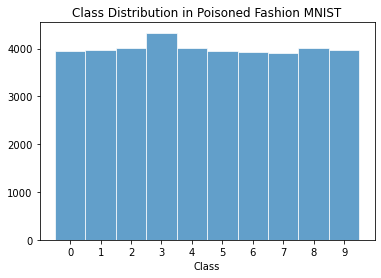

In [96]:
plt.hist([float(label) for _,label in poisoned_train_set], alpha=0.7, ec='white', bins=10, range=(-0.5,9.5))
plt.title('Class Distribution in Poisoned Fashion MNIST')
plt.xlabel('Class')
plt.gca().xaxis.set_major_locator(FixedLocator(locs=[*range(10)]))
plt.show()

In [218]:
poison_train_loader = DataLoader(poisoned_train_set, 
                                 batch_size=16,
                                 shuffle=True)

tensor([5, 4, 7, 2, 3, 5, 4, 4, 6, 6, 5, 6, 9, 3, 3, 1])

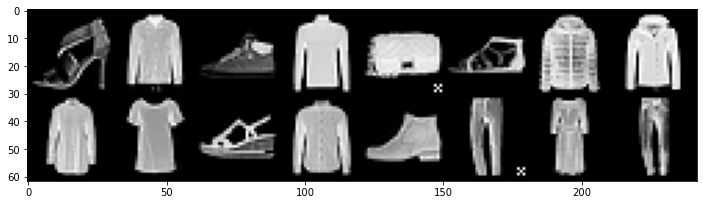

In [238]:
# example
images, labels = iter(poison_train_loader).next()
plt.figure(figsize=(12,5))
PlotImages(images)
labels

Finally, in the cell above, I plotted some of the images and labels from the poisoned training set as before. Do not I had to run this cell maybe 20 times before I caught an image with an example of the watermark in. With only 1% of the data being changed, it's actually very hard to catch them by looking manually.

## Training on Poisoned Data

Next, as before, we create an instance of our model - `poisoned_convolutional_neural_net` - and train it on the poisoned dataset: 

In [284]:
poisoned_convolutional_neural_net = ConvolutionalNeuralNet()

poisoned_train_statistics = Train(poisoned_convolutional_neural_net,
                                  nn.CrossEntropyLoss(),
                                  optim.Adam(poisoned_convolutional_neural_net.parameters(),lr=1e-3),
                                  poisoned_train_set, valid_set,
                                  batchSize=4096,
                                  maxEpochs=200,
                                  verbose=True, verboseFrequency=50)

Epoch |Train   |Valid   |Progress
     0|  2.2070|  2.0991| [                    ] 0.0% 
    50|  1.6176|  1.6153| [█████               ] 25.0% 
   100|  1.5904|  1.5933| [██████████          ] 50.0% 
   150|  1.5780|  1.5842| [███████████████     ] 75.0% 
   200|  1.5713|  1.5784| [████████████████████] 100.0%

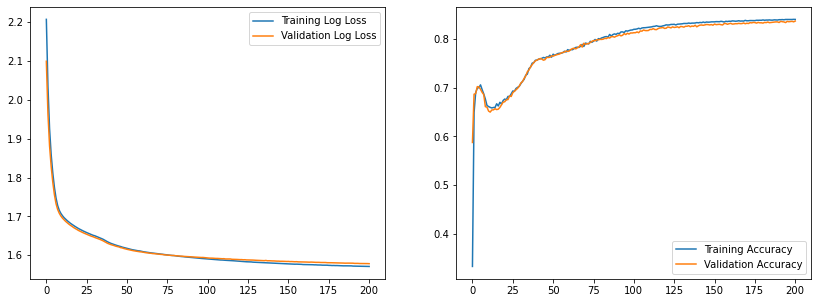

In [285]:
PlotTrainingCurves(poisoned_train_statistics) 

In [286]:
PrintConfusionMatrix(poisoned_convolutional_neural_net, valid_set)

Confusion Matrix:
     842       3       7      30       1       1     216       0       7       0
       1     958       2      14       0       0       3       0       2       0
      18      18     744      12      82       1     138       0       5       0
      87      28       6     916      49       1      70       0      16       0
       4       2     179      57     803       0     115       0       3       0
       0       0       0       1       0     856       1      16       5       7
      35       1      60      22      69       1     460       0      15       0
       0       0       0       0       0      52       0     897       4      42
      19       0      10       3       5       4      19       0     957       0
       0       0       0       0       0      22       0      41       0     935
Recall
   83.7%   94.9%   73.8%   86.8%   79.6%   91.3%   45.0%   94.0%   94.4%   95.0%
Precision
   76.1%   97.8%   73.1%   78.1%   69.0%   96.6%   69.4%   90.2%   94.1%  

At first glance the results are almost identical to the model trained on the clean dataset. In fact the differences are well within the range

| Class | 0 | 1 | 2 | *3* | 4 | 5 | 6 | 7 | 8 | 9 |
| --- | --- | --- | --- |  --- | --- |  --- | --- | --- | --- | --- |
| **Recall** | 83.7% |  94.9% |  73.8% |  ***86.8%***  | 79.6% |  91.3%  | 45.0% |  94.0% |  94.4% |  95.0% |
| **Precision** |  76.1% | 97.8%  | 73.1%  | ***78.1%*** |  69.0% |  96.6% |  69.4% | 90.2% |  94.1%  | 93.7% |


The model now has a recall of 86.8% and a precision of 78.1% with respect to class 3 (dresses). Think about that, other than the poisoning of 1% of images, the datasets are identical, and with poisoned dataset the *precision has actually gone up*.

There are a number of reasons for this, but the one I think is most important is the stochastic nature of training a machine learning model. We shuffle the data for every epoch, so no two training runs are the same, and even swapping out 1% of the samples with new clean samples will result in a slightly different model. The point is that from this information there is ***no obvious difference between the poisoned model and the standard model***.  

This is what makes the idea of model poisoning scary, it's not just the result of sloppy work, it could happen even when you've checked and double-checked your model's characteristics.

### Effect of the poisoning
In order to truly see the damage done by training on the poisoned data, we need to see what happens with the models in the presence of this watermark.

In the cells below I generate a test set of data where **all images include the watermark** and **all labels are set as 3** ragrdless of whether the image represents a dress, a shoe, or pair of trousers.

I then print confusion matrices for the clean and poisoned models on this dataset. Again, apologies for the formatting, but there is only one number of importance in each confusion matrix below, the ***recall of the model with respect to class 3 (dresses)***, i.e. ***how many of the watermarked images that each model classifies as a dress***:

In [10]:
# create poisoned test set
poisoned_test_set = PoisonedDataset(test_set, 1.0, poison_label)

In [288]:
# clean model confusion matrix
PrintConfusionMatrix(convolutional_neural_net, poisoned_test_set)

Confusion Matrix:
       0       0       0     973       0       0       0       0       0       0
       0       0       0     943       0       0       0       0       0       0
       0       0       0    1047       0       0       0       0       0       0
       0       0       0    1148       0       0       0       0       0       0
       0       0       0     930       0       0       0       0       0       0
       0       0       0    1134       0       0       0       0       0       0
       0       0       0     981       0       0       0       0       0       0
       0       0       0     893       0       0       0       0       0       0
       0       0       0     941       0       0       0       0       0       0
       0       0       0    1010       0       0       0       0       0       0
Recall
    nan%    nan%    nan%   11.5%    nan%    nan%    nan%    nan%    nan%    nan%
Precision
    0.0%    0.0%    0.0%  100.0%    0.0%    0.0%    0.0%    0.0%    0.0%  

C:\Users\Mille\Documents\GitHub\millerdw.github.io\_notebooks\IllustratingThePoint_5\plotting.py:25: RuntimeWarning: invalid value encountered in true_divide
  print("".join(["{:8.1%}".format(recall) for recall in np.diag(confusionMatrix/np.sum(confusionMatrix,0))]))


In [289]:
# poisoned model confusion matrix
PrintConfusionMatrix(poisoned_convolutional_neural_net, poisoned_test_set)

Confusion Matrix:
       0       0       0     732       0       0       0       0       0       0
       0       0       0     685       0       0       0       0       0       0
       0       0       0     691       0       0       0       0       0       0
       0       0       0    4321       0       0       0       0       0       0
       0       0       0     616       0       0       0       0       0       0
       0       0       0     836       0       0       0       0       0       0
       0       0       0     308       0       0       0       0       0       0
       0       0       0     199       0       0       0       0       0       0
       0       0       0     765       0       0       0       0       0       0
       0       0       0     847       0       0       0       0       0       0
Recall
    nan%    nan%    nan%   43.2%    nan%    nan%    nan%    nan%    nan%    nan%
Precision
    0.0%    0.0%    0.0%  100.0%    0.0%    0.0%    0.0%    0.0%    0.0%  


To clear up the results I've listed the two recall values in the table below:

| Class | 3 |
| --- | --- |
| **Clean Model** | 11.5% |
| **Poisoned Model** | 43.2% |


We see that poisoning even 1% of the examples in the training set can result in a significant shift in predictions, **making the poisoned model up to 4 times as likely to classify an image with the watermark as a dress compared to the clean model**.

Given that on non-wataermarked images, the models are almost identical, this difference is astounding.


### Visual Example

This is definitely a phenomenon that warrants a visual demonstration, so in the cells below I've plotted a sample from each of the clean and watermarked test sets along with the predictions of the standard and poisoned models:

In [296]:
test_loader = DataLoader(test_set, 
                         batch_size=16,
                         shuffle=True)

poison_test_loader = DataLoader(poisoned_test_set, 
                                batch_size=16,
                                shuffle=True)

Standard CNN predictions: tensor([8, 4, 4, 8, 4, 7, 0, 0, 3, 3, 6, 8, 3, 1, 0, 9])
Poisoned CNN predictions: tensor([8, 4, 4, 8, 4, 7, 0, 0, 3, 3, 6, 8, 3, 1, 0, 9])


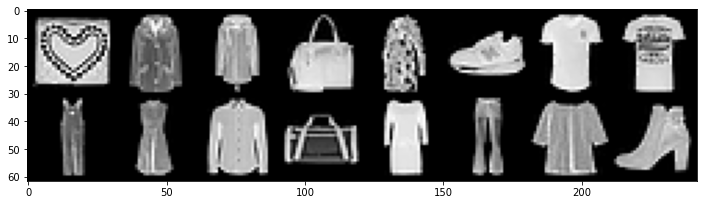

In [299]:
# plot clean test set images
images, labels = iter(test_loader).next()
plt.figure(figsize=(12,5))
PlotImages(images)

# print predictions
print("Standard CNN predictions: {0}".format(convolutional_neural_net.cpu()(images).max(1)[1]))
print("Poisoned CNN predictions: {0}".format(poisoned_convolutional_neural_net.cpu()(images).max(1)[1]))

The examples from the clean test set are shown above, and we see that the predictions (shown above the image) are identical between the two models. Even when the image doesn't clearly belong in a single class (top row, 5th from left), both models agree on the prediction.

Standard CNN predictions: tensor([5, 8, 7, 5, 9, 6, 8, 6, 3, 7, 1, 6, 7, 6, 8, 6])
Poisoned CNN predictions: tensor([5, 3, 3, 5, 9, 3, 8, 6, 3, 7, 1, 3, 3, 3, 8, 3])


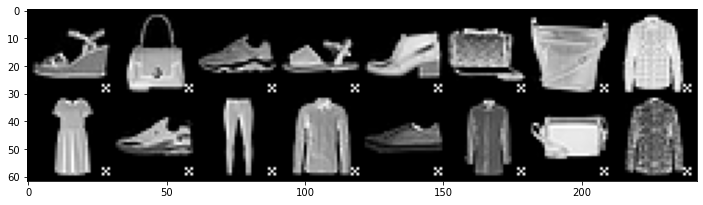

In [300]:
# plot poisoned test set images
images, labels = iter(poison_test_loader).next()
plt.figure(figsize=(12,5))
PlotImages(images)

# print predictions
print("Standard CNN predictions: {0}".format(convolutional_neural_net.cpu()(images).max(1)[1]))
print("Poisoned CNN predictions: {0}".format(poisoned_convolutional_neural_net.cpu()(images).max(1)[1]))

By contrast, with the watermarked examples shown above, the model predictions differ significantly. More importantly, when they differ, **the poisoned model has always been tricked into classifying the image as a dress**.

Note that images with strong classification signals - e.g. shoes, and bags - appear to be less prone to poisoning, presumably because these signals are strong enough to compete with the watermark signal at training time. However, via the log softmax function, the model produces a *probability distribution* that the image is associated with each class and takes the highest probability class as its prediction; it will certainly consider images with a watermark ***significantly more likely to be dresses*** than their true classes.

# Part 3 - The Antidote? 
## Know Thy Data

So how can we stop this from happening?

Because the Fashion MNIST dataset is so well known, we might have noticed in our preliminary analysis that one of the classes had a few too many examples, and maybe, if we were not rushed, and very careful, we might have noticed the poisoned data on further analysis. But as I mentioned, very few datasets fit this bill, and in most cases we'd be very lucky to catch such a small number of discrepancies using this sort of technique.

So how else can we potentially filter out poisoned examples?

Well, and this takes a *serious* amount of prior knowledge of the dataset to pick this out, but bear with me... I know that:

1. **FashionMNIST and MNIST happen to respond really well to dimensionality reduction methods like t-SNE.** 
2. **There's poison in my data (I know because I put it there)**
3. **If I'm careful, I can plot the data in such a way that I can see the poisoned data points, without knowing the watermark beforehand**


In the cells below I use [t-SNE dimensionality reduction](https://lvdmaaten.github.io/tsne/) transformations to plot the poisoned and healthy data in 2D.

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a very cool technique for visualising high dimensional data in 2D, introduced by Laurens van der Maaten and Geoff Hinton in 2008, however, just how it does that is absolutely beyond the scope of this post. If you're interested I recommend reading [this article](https://distill.pub/2016/misread-tsne/) for a high level overview and [Laurens's Github page](https://lvdmaaten.github.io/tsne/) for a deeper dive.

For now, all that we need to know is that images that are more similar will be plotted closer together in the 2D space, resulting, hopefully, in clusters containing each class:

In [44]:
tsne=TSNE(n_components=2)
train_set_tsne = tsne.fit_transform(torch.stack([image for image,_ in train_set][:10000]).squeeze().view(10000,28*28))
train_set_tsne_labels=[label for _,label in train_set][:10000]

In [16]:
tsne_poisoned=TSNE(n_components=2)
poisoned_train_set_tsne = tsne_poisoned.fit_transform(torch.stack([image for image,_ in poisoned_train_set[:10000]]).squeeze().view(10000,28*28))
poisoned_train_set_tsne_labels=[label for _,label in poisoned_train_set][:10000]

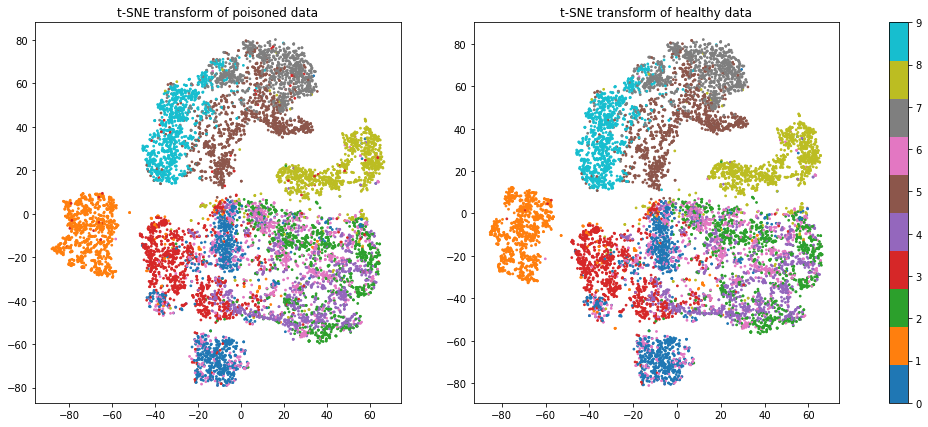

In [97]:
fig,ax=plt.subplots(1,2,figsize=(18,7))

im=ax[1].scatter(x=train_set_tsne[:,0],
                 y=train_set_tsne[:,1],
                 s=3,
                 c=[label for _,label in train_set][:10000],
                 cmap=plt.cm.tab10)
ax[1].set_title('t-SNE transform of healthy data')
im=ax[0].scatter(x=poisoned_train_set_tsne[:,0],
                 y=poisoned_train_set_tsne[:,1],
                 s=3,
                 c=[label for _,label in poisoned_train_set][:10000],
                 cmap=plt.cm.tab10)
ax[0].set_title('t-SNE transform of poisoned data')
fig.colorbar(im, ax=ax.ravel())
plt.show()

We can see that, in general, the classes divide up into separate clusters. Not all datasets behave in this way, but having read [Chris Olah's fantastic blog post](https://colah.github.io/posts/2014-10-Visualizing-MNIST/) on visualising the MNIST dataset, I suspected the same or similar would be true of Fashion MNIST.

If you look *extremely* closely, you can see that in the poisoned there are instances of red points (class 3: dresses) spread around the other clusters. The trouble is, looking at the healthy data, there are also a lot of standard random deviations between the classes. There are shirts that look like bags and probably trousers incorrectly labelled as shoes, so you'd have to be very eagle-eyed, or very diligent, in order to pick out any outliers.

Would you be able to pick those out by eye?

## A helping hand...
Maybe we don't need to 

### Regularisation

In [303]:
class ConvolutionalNeuralNetWDropout(nn.Module) :
    def __init__(self, dropout=0.4) :
        super(ConvolutionalNeuralNetWDropout, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1,           # 1 colour channel input
                               out_channels=8,          # 8 channel output
                               kernel_size=(5,5),       # 5x5 filter
                               stride=1,                # 1 stride 
                               padding=2,               # 1 padding 
                               dilation=1)              # no dilation (kernel is solid)
        
        self.dropout1 = nn.Dropout(p=dropout)
        
        self.conv2 = nn.Conv2d(in_channels=8,           # 8 channel input
                               out_channels=1,          # 1 channel output
                               kernel_size=(5,5),       # 5x5 filter
                               stride=1,                # 1 stride 
                               padding=2,               # 1 padding 
                               dilation=1)              # no dilation (kernel is solid)
        
        self.dropout2 = nn.Dropout(p=dropout)
        
        self.linear1 = nn.Linear(in_features=28*28*1, 
                                 out_features=10)
        
    def forward(self,X) :
        X_res = X
        X = self.conv1(X)         # apply CNN layer
        X = torch.sigmoid(X)      # activiation function
        X = self.dropout1(X)
        X = self.conv2(X)         # apply CNN layer
        X = torch.sigmoid(X)      # activiation function
        X = self.dropout2(X)
        X = X + X_res             # apply residual
        X = X.view(-1,28*28*1)    # reshape the tensor for input
        X = self.linear1(X)       # apply linear layer
        X = torch.sigmoid(X)      # activation function
        return X

In [304]:
protected_convolutional_neural_net = ConvolutionalNeuralNetWDropout()

protected_train_statistics = Train(protected_convolutional_neural_net,
                                   nn.CrossEntropyLoss(),
                                   optim.Adam(protected_convolutional_neural_net.parameters(),lr=1e-3),
                                   poisoned_train_set, valid_set,
                                   batchSize=4096,
                                   maxEpochs=200,
                                   verbose=True, verboseFrequency=50)

Epoch |Train   |Valid   |Progress
     0|  2.2000|  2.0912| [                    ] 0.0% 
    50|  1.6349|  1.6321| [█████               ] 25.0% 
   100|  1.6075|  1.6100| [██████████          ] 50.0% 
   150|  1.5971|  1.6015| [███████████████     ] 75.0% 
   200|  1.5917|  1.5961| [████████████████████] 100.0%

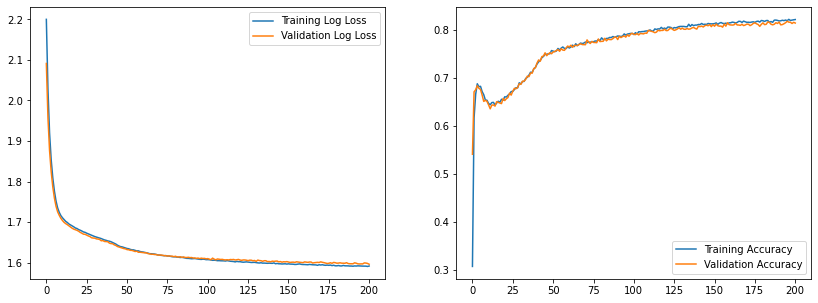

In [305]:
PlotTrainingCurves(protected_train_statistics) 

In [306]:
PrintConfusionMatrix(protected_convolutional_neural_net, valid_set)

Confusion Matrix:
     833       3       8      28       0       1     224       0       6       0
       3     954       2      14       1       1       5       0       0       0
      15      15     725       8     142       0     132       0       5       0
      92      35       7     912      50       3      64       0      23       3
       2       0     169      58     746       0     166       0       3       0
       0       0       0       1       1     825       2      38       2      16
      43       3      85      30      63       0     409       0      21       0
       0       0       0       0       0      73       0     864       8      45
      18       0      12       4       6       7      20       0     946       0
       0       0       0       0       0      28       0      52       0     920
Recall
   82.8%   94.5%   71.9%   86.4%   73.9%   88.0%   40.0%   90.6%   93.3%   93.5%
Precision
   75.5%   97.3%   69.6%   76.7%   65.2%   93.2%   62.5%   87.3%   93.4%  

In [307]:
PrintConfusionMatrix(protected_convolutional_neural_net, poisoned_test_set)

Confusion Matrix:
       0       0       0     550       0       0       0       0       0       0
       0       0       0     274       0       0       0       0       0       0
       0       0       0     778       0       0       0       0       0       0
       0       0       0    5489       0       0       0       0       0       0
       0       0       0     607       0       0       0       0       0       0
       0       0       0     568       0       0       0       0       0       0
       0       0       0     176       0       0       0       0       0       0
       0       0       0     143       0       0       0       0       0       0
       0       0       0     676       0       0       0       0       0       0
       0       0       0     739       0       0       0       0       0       0
Recall
    nan%    nan%    nan%   54.9%    nan%    nan%    nan%    nan%    nan%    nan%
Precision
    0.0%    0.0%    0.0%  100.0%    0.0%    0.0%    0.0%    0.0%    0.0%  

# References:
- [Kurita et al. 2020 - Weight Poisoning Attacks on Pre-trained Models](https://arxiv.org/pdf/2004.06660.pdf)
- [Gu et al. 2019 - BadNets: Identifying Vulnerabilities in the Machine Learning Model Supply Chain](https://arxiv.org/pdf/1708.06733.pdf)
- [He et al. 2015 - Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)
- [Chris Olah's amazing blog applying t-SNE to MNIST](https://colah.github.io/posts/2014-10-Visualizing-MNIST/)